## Example of metric calculation using moving object metrics.

The inputs needed here (the obsfile) can be calculated using the code demonstrated in the [ExampleMoObs](./ExampleMoObs.ipynb) notebook. 

Here, I'm working through how those observations can be read back into the code and metric values (such as discovery chances and then completeness) can be calculated. 

There are definitely some things to be improved upon; if the observation generation stopped at the point of generating interpolations, for example, and the moving object slicer read those interpolations back in, together with the the simdata, it could generate the actual observations on the fly (when using the camera footprint, this would add non-insignificant overhead, so it might actually be nice to be able to do either/both). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from moSlicer import MoSlicer
import moMetrics as MoMetrics
import moSummaryMetrics as MoSummaryMetrics
import moStackers as MoStackers
import moPlots as moPlots
import moMetricBundle as mmb
import lsst.sims.maf.plots as plots

/Users/lynnej/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Set up MoSlicer.  We use the moving object slicer to read the observation data from disk.
test = True
mbas = False
if test:
    orbitfile = 'test.des'
    obsfile = 'test_out.txt'
    runName = 'enigma_1189'
    metadata = '8 NEOs'
    outDir = 'test'
else:
    orbitfile = 'pha20141031.des'
    obsfile = 'pha_withChip_allObs.txt'
    runName = 'enigma_1189'
    metadata = 'PHAS with camera footprint'
    outDir = 'pha'
if mbas:
    orbitfile = 'mbas_10k.des'
    obsfile = 'mbas10k_allObs.txt'
    runName = 'enigma_1189'
    metadata = '10K MBAs'
    outDir = 'mba'

In [3]:
mos = MoSlicer(orbitfile, Hrange=np.arange(13, 26, 0.5))
mos.readObs(obsfile)
print mos.slicePoints['H'], len(mos.slicePoints['H'])
mos.allObs.tail(10)

[ 13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.   18.5
  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.   24.5
  25.   25.5] 26


,objId,delta,ra,dec,magV,time,dradt,ddecdt,phase,solarelon,...,rotSkyPos,filter,finSeeing,fiveSigmaDepth,visitExpTime,solarElong,magFilter,dmagColor,dmagTrail,dmagDetect
2881,9,0.833383,210.269655,-54.068432,22.068274,52838.995531,0.152967,0.304296,39.986026,108.213948,...,6.035570,r,0.832213,24.476917,30,106.933495,21.895967,-0.172307,0.063853,0.056610
2882,9,0.833023,210.577753,-53.754347,22.068616,52840.039728,0.167070,0.306038,40.359691,107.577952,...,5.339050,r,0.880930,24.390284,30,109.176336,21.896309,-0.172307,0.060648,0.053124
2883,9,0.833019,210.581656,-53.750111,22.068628,52840.053557,0.167935,0.306970,40.364822,107.569257,...,5.283188,r,0.893604,24.360415,30,109.166120,21.896321,-0.172307,0.059646,0.052046
2884,9,0.832688,210.897567,-53.449012,22.068897,52841.060268,0.179893,0.306046,40.722974,106.959563,...,5.375496,g,0.891589,24.671769,30,108.428596,22.371217,0.302321,0.061210,0.053731
2885,9,0.832684,210.901977,-53.444524,22.068909,52841.074985,0.180828,0.307027,40.728411,106.950350,...,5.318887,g,0.909625,24.624861,30,108.417679,22.371229,0.302321,0.059683,0.052086
2886,9,0.827764,218.529842,-48.592895,22.061775,52858.021224,0.359113,0.283250,46.481143,97.232219,...,5.353292,y,0.768635,21.487811,30,96.878278,21.759212,-0.302563,0.110489,0.113425
2887,9,0.806960,239.657839,-39.856860,21.972846,52887.982250,0.613241,0.335921,55.490032,83.241605,...,5.126867,z,0.824982,22.005819,30,84.340260,21.674770,-0.298076,0.175914,0.209671
2888,9,0.806935,239.677070,-39.848780,21.972754,52888.006320,0.614494,0.337399,55.497103,83.231731,...,5.123099,z,0.850598,22.378518,30,84.318177,21.674678,-0.298076,0.169895,0.200117
2889,9,0.806921,239.688816,-39.843823,21.972699,52888.020933,0.615728,0.338091,55.501357,83.225729,...,5.093178,z,0.870855,22.328082,30,84.304754,21.674623,-0.298076,0.165370,0.193020
2890,9,0.806908,239.700510,-39.838888,21.972644,52888.035480,0.616957,0.338779,55.505592,83.219754,...,5.057552,z,0.895173,22.270000,30,84.291380,21.674569,-0.298076,0.160112,0.184870


In [4]:
mos.orbits.tail()

,H,M,a,argPeri,e,epoch,g,inc,node,objId,q,sed_filename,tPeri
5,20,176.718411,1.290060,61.550945,0.299100,49353.16,0.15,64.006284,94.372124,5,0.904203,C.dat,49090.445232
6,20,248.565460,1.599622,290.866822,0.503057,49353.16,0.15,23.059935,191.223806,6,0.794920,C.dat,48842.943433
7,20,308.344471,2.171766,98.212633,0.712798,49353.16,0.15,2.523589,74.996555,7,0.623735,C.dat,48351.908052
8,20,155.975807,0.843886,39.981806,0.449921,49353.16,0.15,5.856124,211.448230,8,0.464204,C.dat,49230.480840
9,20,292.517126,1.768293,27.704098,0.422788,49353.16,0.15,22.162646,336.121928,9,1.020680,C.dat,48655.296694


In [5]:
# Set up an example metric bundle.
metric = MoMetrics.NObsMetric()
slicer = mos
pandasConstraint = None
if test:
    plotDict = {'nxbins':20, 'nybins':20}
else:
    plotDict = {'nxbins':100, 'nybins':100}
nobs = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                          runName=runName, metadata=metadata, plotDict=plotDict)

In [6]:
# Calculate completeness. First we must calculate "DiscoveryChances". 
# Set up an example metric bundle.
metric = MoMetrics.DiscoveryMetric()
slicer = mos
pandasConstraint = None
discovery = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                               runName=runName, metadata=metadata, plotDict=plotDict)

In [7]:
# try a different kind of metric, looking at chances of finding activity
metric = MoMetrics.ActivityOverTimeMetric(window=6*30.)
slicer = mos
pandasConstraint = None
activity6month = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                               runName=runName, metadata=metadata, plotDict=plotDict)

In [8]:
bdict = {'nobs':nobs, 'discovery':discovery, 'activity':activity6month}
bg = mmb.MoMetricBundleGroup(bdict, outDir=outDir)
bg.runAll()

AttributeError: 'dict' object has no attribute 'iterValues'

Plotting complete.
Plotted all metrics.


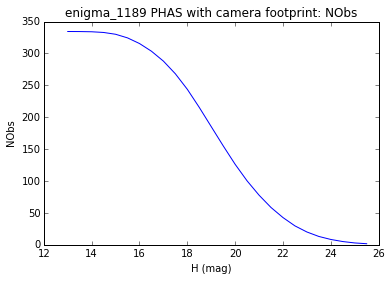

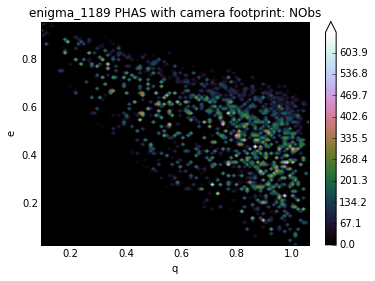

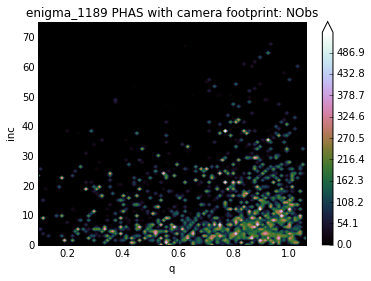

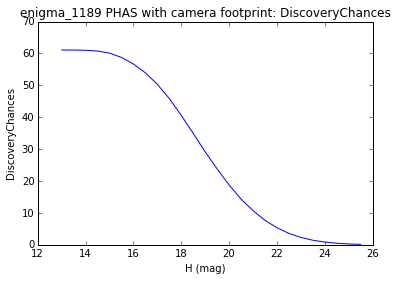

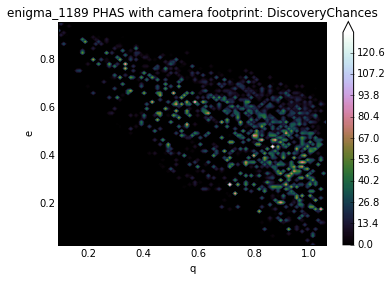

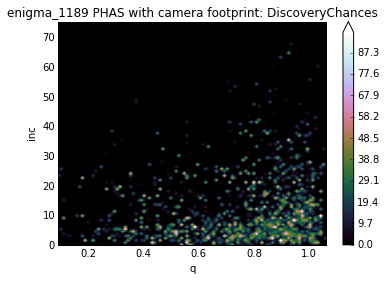

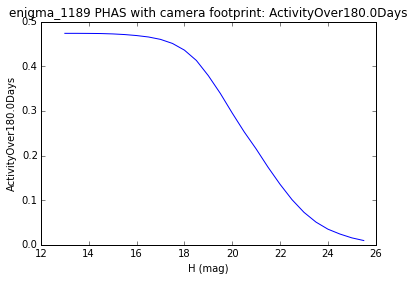

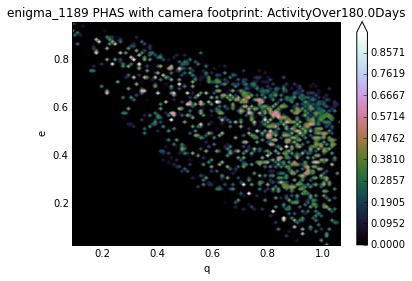

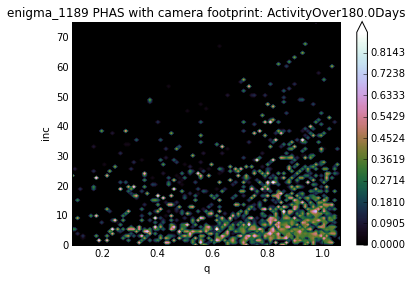

In [9]:
bg.plotAll(closefigs=False)

1

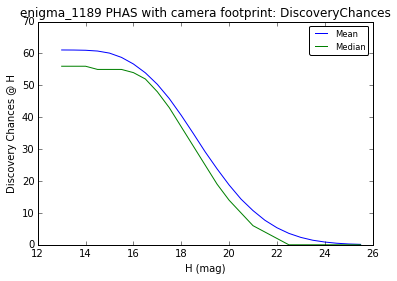

In [10]:
ph = plots.PlotHandler(outDir=outDir)
ph.setMetricBundles([discovery, discovery])
ph.setPlotDicts(plotDicts=[{'npReduce':np.mean, 'color':'b', 'label':'Mean'},
                           {'npReduce':np.median, 'color':'g', 'label':'Median'}])
ph.plot(plotFunc=moPlots.MetricVsH(), plotDicts={'ylabel':'Discovery Chances @ H'})

{'MetricVsH': 1}

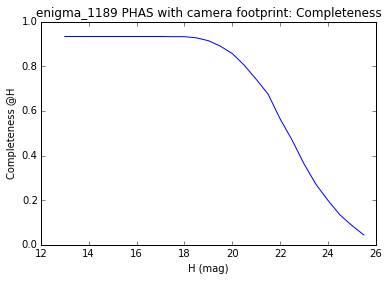

In [11]:
# Then calculate 'completeness' as function of H, as a secondary metric.
completeness = discovery.reduceMetric(discovery.metric.reduceFuncs['Completeness'])
completeness.plot(plotHandler=ph)

{'MetricVsH': 1}

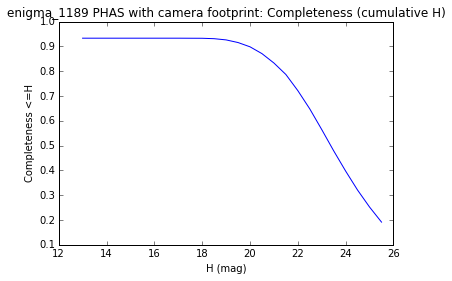

In [12]:
# And we can make an 'integrated over H distribution' version. 
completenessInt = completeness.reduceMetric(completeness.metric.reduceFuncs['CumulativeH'])
completenessInt.plot()

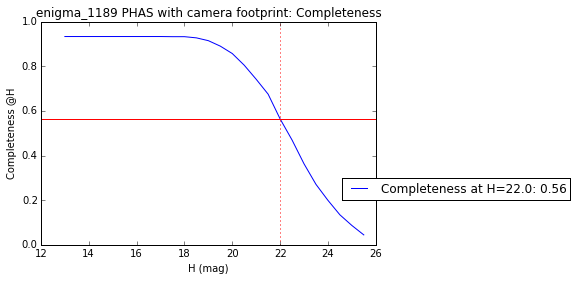

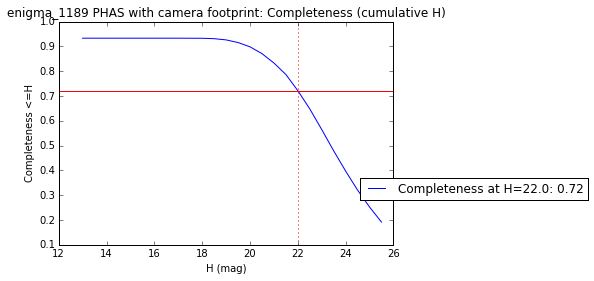

In [15]:
Hmark = 22.0
for c in [completeness, completenessInt]:
    print c
    summaryMetric = ValueAtHMetric(Hmark=Hmark)
    c.setSummaryMetrics(summaryMetric)
    c.computeSummaryStats()
    label = "Completeness at H=%.1f: %.2f" %(Hmark, c.summaryValues['Value At H=%.1f' %Hmark])
    c.setPlotDict({'label':label})
    c.plot(plotFunc = moPlots.MetricVsH())
    plt.axvline(Hmark, color='r', linestyle=':')
    plt.axhline(c.summaryValues['Value At H=%.1f' %(Hmark)], color='r', linestyle='-')
    plt.legend(loc=(0.9, 0.2))

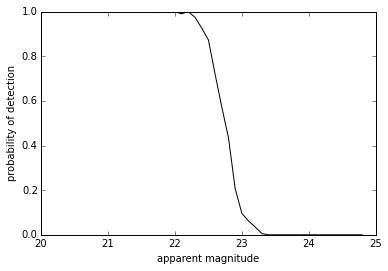

In [14]:
### side note.. illustrating detection probability curve (50% at m5)
# this probability curve is used if snrLimit is NOT set (otherwise it's just a cutoff at snrLimit)
metric = MoMetrics.BaseMoMetric()
# Check what 'visibility' looks like. 
nobjs = 10000
appMag = np.random.rand(nobjs) * 5.0 + 20.0
magLimit = 22.8
vis = metric._calcVis(appMag, magLimit)
bins = np.arange(appMag.min(), appMag.max(), 0.1)
vn, b = np.histogram(appMag[vis], bins=bins)
n, b = np.histogram(appMag, bins=bins)
plt.plot(b[:-1], vn / n.astype(float), 'k-')
plt.xlabel('apparent magnitude')
plt.ylabel('probability of detection')